In [49]:
import math
import copy
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
criterion = nn.MSELoss()

def all_step_error(outputs, labels):
    out = ((outputs-labels)**2)**0.5
    lossVal = torch.mean(out[:,:,0],dim=0)
    err_mean = torch.zeros([6])
    err_final = torch.zeros([6])
    for i in range(6):
        err_mean[i] = torch.mean(lossVal[:5*(i+1)])
        err_final[i] = lossVal[5*(i+1)-1]
    return err_mean, err_final

def step_error(outputs, labels):
    out = ((outputs-labels)**2)**0.5
    lossVal = torch.mean(out[:,:,0],dim=0)
    lossmean = torch.mean(lossVal)
    lossfinal = lossVal[-1]
    
    return lossmean, lossfinal

def model_IDM(inputs_IDM, his_labels):
    v_pred = torch.zeros((inputs_IDM.shape[0], output_length, 1))
    y_pred = torch.zeros((inputs_IDM.shape[0], output_length, 1))
    acc = torch.zeros((inputs_IDM.shape[0], output_length, 1))
    y = inputs_IDM[:,0]
    v = inputs_IDM[:,1]
    s = inputs_IDM[:,2]
    delta_v = inputs_IDM[:,3]
        
    s_x = s_0+ torch.max(torch.tensor(0), v*T+((v*delta_v)/(2*(a*b)**0.5)))
    #s_x = torch.tensor(2.5)+ torch.max(torch.tensor(0), v*torch.tensor(1.25)+((v*delta_v)/(2*(torch.tensor(1.75)*torch.tensor(1.25))**0.5)))
    a_f = a*(1-(v/v_d)**4-(s_x/s)**2)
    #a_f = torch.tensor(1.75)*(1-(v/torch.tensor(30))**4-(s_x/s)**2)
    v_pred[:,0,0] = v+a_f*dt
    for i in range(len(v_pred)):
        if v_pred[i,0,0]<=0:
            v_pred[i,0,0]=0
    y_pred[:,0,0] = y+v_pred[i,0,0]*dt
    acc[:,0,0] = a_f
        
    for i in range(y_pred.shape[0]):
        for j in range(output_length-1):
            v = v_pred[i,j,0]
            delta_v = his_labels[i,j,1]-v_pred[i,j,0]
            s = his_labels[i,j,0]-y_pred[i,j,0]
            #s_x = self.s_0 + self.T*v - ((v * delta_v)/(2*(self.a*self.b)**0.5))
            #s_x = s_0 +  v*T-((v*delta_v)/(2*(a*b)**0.5))
            s_x = s_0 +  torch.max(torch.tensor(0), v*T+((v*delta_v)/(2*(a*b)**0.5)))
            #acc_temp = self.a*(1-(v/self.v_d)**4-(s_x/s)**2)
            acc_temp = a*(1-(v/v_d)**4-(s_x/s)**2)
            v2 = v + acc_temp * dt
            if v2<=0:
                v2 = 0
                acc_temp = (v2-v)/dt
            y1 = y_pred[i,j,0]
            y2 = y1 + v2 * dt
            acc[i,j+1,0] = acc_temp
            v_pred[i,j+1,0] = v2
            y_pred[i,j+1,0] = y2
                   
    return y_pred

class IDMModel(nn.Module):
    def __init__(self, s_0, T, a, b, v_d):
        super(IDMModel, self).__init__()
        self.model_type = 'IDM'
        self.dt=0.1
        self.s_0 = torch.tensor([1.667], requires_grad=True)
        self.T = torch.tensor([0.504], requires_grad=True)
        self.a = torch.tensor([0.430], requires_grad=True)
        self.b = torch.tensor([3.216], requires_grad=True)
        self.v_d = torch.tensor([16.775], requires_grad=True)
        
        self.s_0 = torch.nn.Parameter(self.s_0)
        self.T = torch.nn.Parameter(self.T)
        self.a = torch.nn.Parameter(self.a)
        self.b = torch.nn.Parameter(self.b)
        self.v_d = torch.nn.Parameter(self.v_d)
        
        self.s_0.data.fill_(s_0)
        self.T.data.fill_(T)
        self.a.data.fill_(a)
        self.b.data.fill_(b)
        self.v_d.data.fill_(v_d)
    def forward(self, inputs_IDM, his_labels):
        y = inputs_IDM[:,0]
        v = inputs_IDM[:,1]
        s = inputs_IDM[:,2]
        delta_v = inputs_IDM[:,3]
        
        s_x = self.s_0+  v*self.T+((v*delta_v)/(2*(self.a*self.b)**0.5))
        a_f = self.a*(1-(v/self.v_d)**4-(s_x/s)**2)
        v_pred = v+a_f*self.dt
        for i in range(len(v_pred)):
            if v_pred[i]<=0:
                v_pred[i]==0
        output_IDM = y+v_pred*self.dt
        return output_IDM.unsqueeze(1).unsqueeze(2), torch.Tensor(self.s_0.data.cpu().numpy()), torch.Tensor(self.T.data.cpu().numpy()), torch.Tensor(self.a.data.cpu().numpy()), torch.Tensor(self.b.data.cpu().numpy()), torch.Tensor(self.v_d.data.cpu().numpy())

class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout, fusion_size, output_length):
        super(TransformerModel, self).__init__()
        
        self.model_type = 'Transformer'
        self.src_mask = None
        self.embedding_layer = nn.Linear(ninput, ninp)
        self.encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(self.encoder_layers, nlayers)
        #self.relu = nn.ReLU()
        #self.leaky_relu = nn.LeakyReLU(0.1)
        #self.sig = nn.Sigmoid()
        self.decoder = nn.Linear(ninp, ntokens)
        self.dropout_in = nn.Dropout(dropout)
        self.fusion_layer_1 = nn.Linear(fusion_size, ntokens)
        self.fusion_layer_2 = nn.Linear(fusion_size, ntokens)
        self.out_length = output_length
        
        #self.pos_encoder = PositionalEncoding(ninp, dropout)
        
        #self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 1
        #self.transformer_encoder.weight.data.uniform_(-initrange, initrange)
        self.embedding_layer.bias.data.zero_()
        self.embedding_layer.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)
    def forward(self, inputs, his_labels):
        
        src_inputs = inputs[:,:,0].unsqueeze(2)
        src = src_inputs.transpose(1,0)
        src = self.embedding_layer(src)
        #pos_src = self.pos_encoder(src)
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            mask = self._generate_square_subsequent_mask(len(src))
            self.src_mask = mask
        
        enc_src = self.transformer_encoder(src, self.src_mask)
        enc_src = enc_src[-1]
        enc_src = enc_src.repeat(self.out_length, 1, 1)
        output = self.decoder(enc_src)
        output = output.transpose(0,1)
        
        dv = (src_inputs[:,-1,0]-src_inputs[:,-31,0])/30
        hist = torch.zeros(output.shape)
        for i in range(src_inputs.shape[0]):
            hist[i,:,0] = torch.linspace(src_inputs[i,-1,0].item(), src_inputs[i,-1,0].item()+dv[i].item()*30, 31)[1:]
        output_IDM = model_IDM(inputs[:,-1,:], his_labels[:,:,:])
        fusion_1 = torch.cat([output,hist,output_IDM],axis=2)
        final_output = self.fusion_layer_1(fusion_1)
        
        #fusion_2 = torch.cat([fusion_output,hist],axis=1)
        #final_output = self.fusion_layer_2(fusion_2)
        
        return final_output


In [50]:
class PINN(nn.Module):
    def __init__(self, s_0, T, a, b, v_d, ntokens, ninp, nhead, nhid, nlayers, dropout, fusion_size):
        super(PINN, self).__init__()
        self.dt = 0.1
        self.output_length = 30
        #self.s_0 = torch.tensor(s_0, requires_grad=True)
        #self.T = torch.tensor(T, requires_grad=True)
        #self.a = torch.tensor(a, requires_grad=True)
        #self.b = torch.tensor(b, requires_grad=True)
        #self.v_d = torch.tensor(v_d, requires_grad=True)
        
        #self.s_0 = torch.nn.Parameter(self.s_0)
        #self.T = torch.nn.Parameter(self.T)
        #self.a = torch.nn.Parameter(self.a)
        #self.b = torch.nn.Parameter(self.b)
        #self.v_d = torch.nn.Parameter(self.v_d)
        
        self.PUNN = TransformerModel(ntokens, ninp, nhead, nhid, nlayers, dropout, fusion_size,self.output_length)
        self.PINN = IDMModel(s_0, T, a, b, v_d)
        
        #self.Transformer.register_parameter('s_0', self.s_0)
        #self.Transformer.register_parameter('T', self.T)
        #self.Transformer.register_parameter('a', self.a)
        #self.Transformer.register_parameter('b', self.b)
        #self.Transformer.register_parameter('v_d', self.v_d)
        
        #self.optimizer = torch.optim.Adam(self.Transformer.parameters(), lr=0.00005)
        self.optimizer = torch.optim.Adam([{'params':self.PUNN.parameters(), 'lr':0.0005},{'params':self.PINN.parameters(),'lr':0.0000001}])
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 15, gamma=0.1)
        #self.optimizer_PUNN = torch.optim.Adam(self.PUNN.parameters(), lr=0.0005)
        #self.scheduler_PUNN = torch.optim.lr_scheduler.StepLR(self.optimizer_PUNN, 15, gamma=0.1)
        #self.optimizer_PINN = torch.optim.Adam(self.PINN.parameters(), lr=0.0005)
        #self.scheduler_PINN = torch.optim.lr_scheduler.StepLR(self.optimizer_PINN, 15, gamma=0.1)
        #self.optimizer = torch.optim.Adam(self.Transformer.parameters())
        self.epoches = 10
        self.alpha = 0.7
        
    def net_PUNN(self, inputs, his_labels):
        output_trans = self.PUNN(inputs, his_labels)
        return output_trans
    
    def net_PINN(self, inputs_IDM, his_labels):
        output_IDM = self.PINN(inputs_IDM, his_labels)
        return output_IDM
    
    def PINN_without_grad(self, inputs_IDM, his_labels, s_0_item, T_item, a_item, b_item, vd_item):
        v_pred = torch.zeros((inputs_IDM.shape[0], self.output_length, 1))
        y_pred = torch.zeros((inputs_IDM.shape[0], self.output_length, 1))
        acc = torch.zeros((inputs_IDM.shape[0], self.output_length, 1))
        y = inputs_IDM[:,0]
        v = inputs_IDM[:,1]
        s = inputs_IDM[:,2]
        delta_v = inputs_IDM[:,3]
        
        #s_0_item = torch.Tensor(self.s_0.data.cpu().numpy())
        #T_item = torch.Tensor(self.T.data.cpu().numpy())
        #a_item = torch.Tensor(self.a.data.cpu().numpy())
        #b_item = torch.Tensor(self.b.data.cpu().numpy())
        #vd_item = torch.Tensor(self.v_d.data.cpu().numpy())
        s_x = s_0_item+ torch.max(torch.tensor(0), v*T_item+((v*delta_v)/(2*(a_item*b_item)**0.5)))
        #s_x = torch.tensor(2.5)+ torch.max(torch.tensor(0), v*torch.tensor(1.25)+((v*delta_v)/(2*(torch.tensor(1.75)*torch.tensor(1.25))**0.5)))
        a_f = a_item*(1-(v/vd_item)**4-(s_x/s)**2)
        #a_f = torch.tensor(1.75)*(1-(v/torch.tensor(30))**4-(s_x/s)**2)
        v_pred[:,0,0] = v+a_f*self.dt
        for i in range(len(v_pred)):
            if v_pred[i,0,0]<=0:
                v_pred[i,0,0]=0
        y_pred[:,0,0] = y+v_pred[i,0,0]*self.dt
        acc[:,0,0] = a_f
        
        for i in range(y_pred.shape[0]):
            for j in range(self.output_length-1):
                v = v_pred[i,j,0]
                delta_v = his_labels[i,j,1]-v_pred[i,j,0]
                s = his_labels[i,j,0]-y_pred[i,j,0]
                #s_x = self.s_0 + self.T*v - ((v * delta_v)/(2*(self.a*self.b)**0.5))
                s_x = s_0_item+  torch.max(torch.tensor(0),v*T_item+((v*delta_v)/(2*(a_item*b_item)**0.5)))
                #acc_temp = self.a*(1-(v/self.v_d)**4-(s_x/s)**2)
                acc_temp = a_item*(1-(v/vd_item)**4-(s_x/s)**2)
                v2 = v + acc_temp * self.dt
                if v2 <= 0:
                    v2 = 0
                    acc_temp = (v2-v)/self.dt
                y1 = y_pred[i,j,0]
                y2 = y1 + v2 * self.dt
                acc[i,j+1,0] = acc_temp
                v_pred[i,j+1,0] = v2
                y_pred[i,j+1,0] = y2
        return y_pred
    
    def train(self):
        #the training part has been deleted because the confidentiality agreement
    def predict(self, inputs, his_labels, model_location):
        #self.Transformer = TransformerModel(ntokens, ninp, nhead, nhid, nlayers, dropout, fusion_size)
        self.PUNN.load_state_dict(torch.load(model_location))
        #self.Transformer = model
        self.PUNN.eval()
        out_Trans = self.PUNN(inputs, his_labels)
        #out_IDM = self.net_IDM(inputs[:,-1,:], labels)
        return out_Trans


In [51]:
s_0 = (1.667/0.3048)/(max_num-min_num)
T = 0.504
a = (0.430/0.3048)/(max_num-min_num)
b = (3.216/0.3048)/(max_num-min_num)
v_d = (16.775/0.3048)/(max_num-min_num)

ntokens = 1 # the size of outputs
ninput = 1
ninp = 14 # embedding dimension
nhid = 28 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 3 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
fusion_size = 3
dropout = 0.1 # the dropout value
dt = 0.1
output_length = 30

PIT_IDM = PINN(s_0, T, a, b, v_d, ntokens, ninp, nhead, nhid, nlayers, dropout, fusion_size)
model_location = r'\PIT-IDM(1)_I80.tar'

In [3]:
import pandas as pd
import numpy as np

lane_keep_data=pd.read_csv(r'\lane_keep_data_I80.csv')

pro_data_all = lane_keep_data[['Vehicle_ID', 'Frame_ID', 'Local_Y', 'Pre_Local_Y', 'y_v', 'Space_Headway', 'delta_v', 'Preceding', 'Pre_yv']]
pro_data = pro_data_all.to_numpy()

##Training Data
all_input=[]
for i in range(int(pro_data.shape[0]*0.8)-2*50):
    if pro_data[i, 0] == pro_data[i + 49, 0] and pro_data[i, 7] == pro_data[i + 49, 7] and pro_data[i + 49, 1] - pro_data[
        i, 1] == 49 and pro_data[i + 49, 0] == pro_data[i + 98, 0] and pro_data[i + 49, 7] == pro_data[i + 98, 7] and pro_data[i + 98, 1] - \
            pro_data[i + 49, 1] == 49:
        no_use = pro_data[i + 50:i + 2 * 50]
        no_use = np.array(no_use)
        the_output = no_use[:, :]
        all_together = np.hstack((pro_data[i: i + 50][:, :], the_output))
        all_input.append(all_together)

x_train = []
y_train = []
train_labels = []
for i in range(len(all_input)):
    temp = all_input[i]
    temp_y = temp[:30,11]-temp[0,2]
    temp_y_pre = temp[:30,12]-temp[0,2]
    temp_yv_pre = temp[:30,-1]
    begin_pos = temp[0,2]
    temp[:,2] = temp[:,2] - begin_pos
    temp[:,3] = temp[:,3] - begin_pos
    if temp_y[0]<=temp[-1,2] or temp_y[0]<=0 or temp_y[0]>=temp_y_pre[0]:
        continue
    y_train.append([temp_y])
    train_labels.append([temp_y_pre, temp_yv_pre])
    x_train.append(temp[:,[2,4,5,6]])

##Validation Data
all_input = []
for i in range(int(pro_data.shape[0]*0.9), int(pro_data.shape[0])-2*50):
    if pro_data[i, 0] == pro_data[i + 49, 0] and pro_data[i, 7] == pro_data[i + 49, 7] and pro_data[i + 49, 1] - pro_data[
        i, 1] == 49 and pro_data[i + 49, 0] == pro_data[i + 98, 0] and pro_data[i + 49, 7] == pro_data[i + 98, 7] and pro_data[i + 98, 1] - \
            pro_data[i + 49, 1] == 49:
        no_use = pro_data[i + 50:i + 2 * 50]
        no_use = np.array(no_use)
        the_output = no_use[:, :]
        all_together = np.hstack((pro_data[i: i + 50][:, :], the_output))
        all_input.append(all_together)

x_val = []
y_val = []
val_labels = []
for i in range(len(all_input)):
    temp = all_input[i]
    temp_y = temp[:30,11]-temp[0,2]
    temp_y_pre = temp[:30,12]-temp[0,2]
    temp_yv_pre = temp[:30,-1]
    begin_pos = temp[0,2]
    temp[:,2] = temp[:,2] - begin_pos
    temp[:,3] = temp[:,3] - begin_pos
    if temp_y[0]<=temp[-1,2] or temp_y[0]<=0 or temp_y[0]>=temp_y_pre[0]:
        continue
    y_val.append([temp_y])
    val_labels.append([temp_y_pre, temp_yv_pre])
    x_val.append(temp[:,[2,4,5,6]])

##Testing Data
all_input = []
for i in range(int(pro_data.shape[0]*0.8), int(pro_data.shape[0]*0.9)-2*50):
    if pro_data[i, 0] == pro_data[i + 49, 0] and pro_data[i, 7] == pro_data[i + 49, 7] and pro_data[i + 49, 1] - pro_data[
        i, 1] == 49 and pro_data[i + 49, 0] == pro_data[i + 98, 0] and pro_data[i + 49, 7] == pro_data[i + 98, 7] and pro_data[i + 98, 1] - \
            pro_data[i + 49, 1] == 49:
        no_use = pro_data[i + 50:i + 2 * 50]
        no_use = np.array(no_use)
        the_output = no_use[:, :]
        all_together = np.hstack((pro_data[i: i + 50][:, :], the_output))
        all_input.append(all_together)

x_test = []
y_test = []
test_labels = []
for i in range(len(all_input)):
    temp = all_input[i]
    temp_y = temp[:30,11]-temp[0,2]
    temp_y_pre = temp[:30,12]-temp[0,2]
    temp_yv_pre = temp[:30,-1]
    begin_pos = temp[0,2]
    temp[:,2] = temp[:,2] - begin_pos
    temp[:,3] = temp[:,3] - begin_pos
    if temp_y[0]<=temp[-1,2] or temp_y[0]<=0 or temp_y[0]>=temp_y_pre[0]:
        continue
    y_test.append([temp_y])
    test_labels.append([temp_y_pre, temp_yv_pre])
    x_test.append(temp[:,[2,4,5,6]])

x_train = np.array(x_train)
y_train = np.array(y_train)
train_labels = np.array(train_labels)
y_train = y_train.transpose(0,2,1)
train_labels = train_labels.transpose(0,2,1)

x_test = np.array(x_test)
y_test = np.array(y_test)
test_labels = np.array(test_labels)
y_test = y_test.transpose(0,2,1)
test_labels = test_labels.transpose(0,2,1)

x_val = np.array(x_val)
y_val = np.array(y_val)
val_labels = np.array(val_labels)
y_val = y_val.transpose(0,2,1)
val_labels = val_labels.transpose(0,2,1)

max_num = max([np.max(x_train[:,:,0]),np.max(y_train[:,:,0]),np.max(x_test[:,:,0]),np.max(y_test[:,:,0]),np.max(x_val[:,:,0]),np.max(y_val[:,:,0])])
min_num = min([np.min(x_train[:,:,0]),np.min(y_train[:,:,0]),np.min(x_test[:,:,0]),np.min(y_test[:,:,0]),np.min(x_val[:,:,0]),np.min(y_val[:,:,0])])

x_train[:,:,[0]] = x_train[:,:,[0]]-min_num
y_train[:,:,[0]] = y_train[:,:,[0]]-min_num
train_labels[:,:,[0]] = train_labels[:,:,[0]]-min_num
x_test[:,:,[0]] = x_test[:,:,[0]]-min_num
y_test[:,:,[0]] = y_test[:,:,[0]]-min_num
test_labels[:,:,[0]] = test_labels[:,:,[0]]-min_num
x_val[:,:,[0]] = x_val[:,:,[0]]-min_num
y_val[:,:,[0]] = y_val[:,:,[0]]-min_num
val_labels[:,:,[0]] = val_labels[:,:,[0]]-min_num

x_train = x_train/(max_num-min_num)
y_train = y_train/(max_num-min_num)
train_labels = train_labels/(max_num-min_num)
x_test = x_test/(max_num-min_num)
y_test = y_test/(max_num-min_num)
test_labels = test_labels/(max_num-min_num)
x_val = x_val/(max_num-min_num)
y_val = y_val/(max_num-min_num)
val_labels = val_labels/(max_num-min_num)

In [4]:
dt = 0.1
all_input=[]
for i in range(int(pro_data.shape[0]*0.8), int(pro_data.shape[0]*0.9)-2*50):
    if pro_data[i, 0] == pro_data[i + 49, 0] and pro_data[i, 7] == pro_data[i + 49, 7] and pro_data[i + 49, 1] - pro_data[
        i, 1] == 49 and pro_data[i + 49, 0] == pro_data[i + 98, 0] and pro_data[i + 49, 7] == pro_data[i + 98, 7] and pro_data[i + 98, 1] - \
            pro_data[i + 49, 1] == 49:
        no_use = pro_data[i + 50:i + 2 * 50]
        no_use = np.array(no_use)
        the_output = no_use[:, :]
        all_together = np.hstack((pro_data[i: i + 50][:, :], the_output))
        all_input.append(all_together)

x_test = []
y_test = []
test_labels = []
test_pre_labels = []
for i in range(len(all_input)):
    temp = all_input[i]
    temp_y = temp[:30,11]-temp[0,2]
    temp_y_pre = temp[:30,12]-temp[0,2]
    temp_yv_pre = temp[:30,-1]
    begin_pos = temp[0,2]
    temp[:,2] = temp[:,2] - begin_pos
    temp[:,3] = temp[:,3] - begin_pos
    if temp_y[0]<=temp[-1,2] or temp_y[0]<=0 or temp_y[0]>=temp_y_pre[0]:
        continue
    yv_pre = temp[-1, 8]
    y_pre = temp[-1, 3]
    if yv_pre != 0:
        test_yv_pre = yv_pre*np.ones(30)
        test_y_pre = np.linspace(y_pre, y_pre+yv_pre*30*dt,31)[1:]
    else:
        test_yv_pre = np.zeros(30)
        test_y_pre = np.linspace(y_pre, y_pre+temp[-1,4]*30*dt,31)[1:]
    y_test.append([temp_y])
    test_labels.append([temp_y_pre, temp_yv_pre])
    x_test.append(temp[:,[2,4,5,6]])
    test_pre_labels.append([test_y_pre, test_yv_pre])
    
x_test = np.array(x_test)
y_test = np.array(y_test)
test_labels = np.array(test_labels)
test_pre_labels = np.array(test_pre_labels)
y_test = y_test.transpose(0,2,1)
test_labels = test_labels.transpose(0,2,1)
test_pre_labels = test_pre_labels.transpose(0,2,1)

x_test[:,:,[0]] = x_test[:,:,[0]]-min_num
y_test[:,:,[0]] = y_test[:,:,[0]]-min_num
test_labels[:,:,[0]] = test_labels[:,:,[0]]-min_num
test_pre_labels[:,:,[0]] = test_pre_labels[:,:,[0]]-min_num

x_test = x_test/(max_num-min_num)
y_test = y_test/(max_num-min_num)
test_labels = test_labels/(max_num-min_num)
test_pre_labels = test_pre_labels/(max_num-min_num)

In [5]:
all_input = []
for i in range(int(pro_data.shape[0]*0.8), int(pro_data.shape[0]*0.9)-2*50):
    if pro_data[i, 0] == pro_data[i + 49, 0] and pro_data[i, 7] == pro_data[i + 49, 7] and pro_data[i + 49, 1] - pro_data[
        i, 1] == 49 and pro_data[i + 49, 0] == pro_data[i + 98, 0] and pro_data[i + 49, 7] == pro_data[i + 98, 7] and pro_data[i + 98, 1] - \
            pro_data[i + 49, 1] == 49:
        no_use = pro_data[i + 50:i + 2 * 50]
        no_use = np.array(no_use)
        the_output = no_use[:, :]
        all_together = np.hstack((pro_data[i: i + 50][:, :], the_output))
        all_input.append(all_together)

begin_positions = []
for i in range(len(all_input)):
    temp = all_input[i]
    temp_y = temp[:30,11]-temp[0,2]
    temp_y_pre = temp[:30,12]-temp[0,2]
    temp_yv_pre = temp[:30,-1]
    begin_pos = temp[0,2]
    temp[:,2] = temp[:,2] - begin_pos
    temp[:,3] = temp[:,3] - begin_pos
    if temp_y[0]<=temp[-1,2] or temp_y[0]<=0 or temp_y[0]>=temp_y_pre[0]:
        continue
    begin_positions.append(begin_pos)


In [6]:
from torch.utils.data import sampler, Dataset, DataLoader
import torch

class TrajectoryData(Dataset):
    """
    A customized data loader for Traffic.
    """
    def __init__(self,matrixs,labels,history_labels):
        """ Intialize the Traffic dataset
        
        Args:
            - data: numpy datatype
        """
        self.matrixs = torch.DoubleTensor(matrixs.astype(float))
        self.matrixs = self.matrixs.to(torch.float32)
        self.labels =  torch.DoubleTensor(labels.astype(float))
        self.labels = self.labels.to(torch.float32)
        self.history_labels = torch.DoubleTensor(history_labels.astype(float))
        self.history_labels = self.history_labels.to(torch.float32)
        self.len = matrixs.shape[0]
    # probably the most important to customize.
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        matrix = self.matrixs[index]
        label = self.labels[index]
        history_label = self.history_labels[index]
        return matrix,label,history_label

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len


In [7]:
trainset = TrajectoryData(x_train, y_train, train_labels)
trainset_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0, drop_last=True)
valset = TrajectoryData(x_val, y_val, val_labels)
valset_loader = DataLoader(valset, batch_size=32, shuffle=False, num_workers=0, drop_last=True)
testset = TrajectoryData(x_test, y_test, test_pre_labels)
testset_loader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=0, drop_last=True)

dataloaders={}
dataloaders['train']=trainset_loader
dataloaders['val']=valset_loader
dataloaders['test']=testset_loader
dataset_sizes={}
dataset_sizes['train']=len(x_train)
dataset_sizes['val']=len(x_val)
dataset_sizes['test']=len(x_test)

In [10]:
import math
import copy
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn import TransformerDecoder, TransformerDecoderLayer
import torch.nn as nn
import math

def subsequent_mask(size):
    """
    Mask out subsequent positions.
    """
    attn_shape = (1, size, size)
    mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(mask) == 0

def _generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]
    
class Transformer(nn.Module):
    def __init__(self, ninput, ntoken, ninp, nhead, nhid, nlayers, dropout):
        super(Transformer, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.encoder_pos = PositionalEncoding(ninp)
        self.encoder_emb = nn.Linear(ninput, ninp)
        self.encoder_layer = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.encoder = TransformerEncoder(self.encoder_layer, nlayers)
        self.decoder_emb = nn.Linear(ninput, ninp)
        self.decoder_layer = TransformerDecoderLayer(ninp, nhead, nhid, dropout)
        self.decoder = TransformerDecoder(self.decoder_layer, nlayers)
        self.output_layer = nn.Linear(ninp, ntoken)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.encoder_emb.bias.data.zero_()
        self.encoder_emb.weight.data.uniform_(-initrange, initrange)
        self.decoder_emb.bias.data.zero_()
        self.decoder_emb.weight.data.uniform_(-initrange, initrange)
        self.output_layer.bias.data.zero_()
        self.output_layer.weight.data.uniform_(-initrange, initrange)

    def forward(self, inputs, dec_input, target_mask):
        src = self.encoder_pos(self.encoder_emb(inputs.transpose(0,1)))
        memory = self.encoder(src)
        inp_decoder = self.decoder_emb(dec_input.transpose(0,1))
        out_decoder = self.decoder(inp_decoder, memory, target_mask)
        output = self.output_layer(out_decoder)
        return output.transpose(0,1)

ninput = 1
ntoken = 1
ninp = 50
nhead = 10
nhid = 50
dropout = 0.1
nlayers = 2
Trans_model_location = r'\Transformer_I80.tar'
Trans_model = Transformer(ninput, ntoken, ninp, nhead, nhid, nlayers, dropout)
Trans_model.load_state_dict(torch.load(Trans_model_location))

<All keys matched successfully>

In [11]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [52]:
a_item = (1.317/0.3048)/(max_num-min_num)
b_item = (1.625/0.3048)/(max_num-min_num)
v_d_item = (13.853/0.3048)/(max_num-min_num)
s_0_item = (2.600/0.3048)/(max_num-min_num)
T_item = 1.279
dt = 0.1
output_length = 30
def model_IDM_test(inputs_IDM, his_labels, output_length):
    v_pred = torch.zeros((inputs_IDM.shape[0], output_length, 1))
    y_pred = torch.zeros((inputs_IDM.shape[0], output_length, 1))
    acc = torch.zeros((inputs_IDM.shape[0], output_length, 1))
    y = inputs_IDM[:,0]
    v = inputs_IDM[:,1]
    s = inputs_IDM[:,2]
    delta_v = inputs_IDM[:,3]
    
    s_x = s_0_item + torch.max(torch.tensor(0), v*T_item+((v*delta_v)/(2*(a_item*b_item)**0.5)))
    #s_x = torch.tensor(2.5)+ torch.max(torch.tensor(0), v*torch.tensor(1.25)+((v*delta_v)/(2*(torch.tensor(1.75)*torch.tensor(1.25))**0.5)))
    a_f = a_item*(1-(v/v_d_item)**4-(s_x/s)**2)
    #a_f = torch.tensor(1.75)*(1-(v/torch.tensor(30))**4-(s_x/s)**2)
    v_pred[:,0,0] = v+a_f*dt
    for i in range(len(v_pred)):
        if v_pred[i,0,0]<=0:
            v_pred[i,0,0]=0
    y_pred[:,0,0] = y+v_pred[i,0,0]*dt
    acc[:,0,0] = a_f
        
    for i in range(y_pred.shape[0]):
        for j in range(output_length-1):
            v = v_pred[i,j,0]
            delta_v = his_labels[i,j,1]-v_pred[i,j,0]
            s = his_labels[i,j,0]-y_pred[i,j,0]
            #s_x = self.s_0 + self.T*v - ((v * delta_v)/(2*(self.a*self.b)**0.5))
            #s_x = s_0 +  v*T-((v*delta_v)/(2*(a*b)**0.5))
            s_x = s_0_item +  torch.max(torch.tensor(0), v*T_item+((v*delta_v)/(2*(a_item*b_item)**0.5)))
            #acc_temp = self.a*(1-(v/self.v_d)**4-(s_x/s)**2)
            acc_temp = a_item*(1-(v/v_d_item)**4-(s_x/s)**2)
            v2 = v + acc_temp * dt
            if v2<=0:
                v2 = 0
                acc_temp = (v2-v)/dt
            y1 = y_pred[i,j,0]
            y2 = y1 + v2 * dt
            acc[i,j+1,0] = acc_temp
            v_pred[i,j+1,0] = v2
            y_pred[i,j+1,0] = y2
                   
    return y_pred


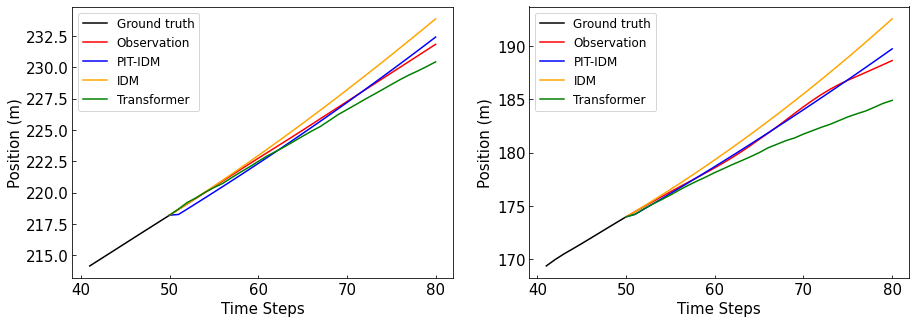

In [57]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

i = 155
inputs = torch.from_numpy(x_test[300*i+200,:,:]).unsqueeze(0).to(torch.float32)
hist_labels = torch.from_numpy(test_pre_labels[300*i+200,:,:]).unsqueeze(0).to(torch.float32)
labels = torch.from_numpy(y_test[300*i+200,:,:]).unsqueeze(0).to(torch.float32)
inputs_trans = inputs[:,:,[0]]
start_of_seq = torch.Tensor([0]).unsqueeze(0).unsqueeze(1).repeat(labels.shape[0],1,1)
dec_input = start_of_seq
for j in range(output_length):
    target_mask = _generate_square_subsequent_mask(dec_input.shape[1])
    output_trans = Trans_model(inputs_trans, dec_input, target_mask)
    dec_input = torch.cat((dec_input, output_trans[:,-1:,:]),1)
    outputs_trans = dec_input[:,1:,:]
outputs = PIT_IDM.predict(inputs, hist_labels, model_location)
outputs_IDM = model_IDM_test(inputs[:,-1,:], hist_labels[:,:,:],output_length)
y_label = labels[0,:,0].detach().numpy()*(max_num-min_num)
y_output = outputs[0,:,0].detach().numpy()*(max_num-min_num)
y_output_IDM = outputs_IDM[0,:,0].detach().numpy()*(max_num-min_num)
y_output_trans = outputs_trans[0,:,0].detach().numpy()*(max_num-min_num)
x_pred = np.arange(1,32)+49
x_obs = np.arange(1,51)
y_obs = inputs[0,:,0].detach().numpy()*(max_num-min_num)
y_label = np.concatenate((np.array([y_obs[-1]]),y_label))
y_output= np.concatenate((np.array([y_obs[-1]]),y_output))
y_output_IDM = np.concatenate((np.array([y_obs[-1]]),y_output_IDM))
y_output_trans = np.concatenate((np.array([y_obs[-1]]),y_output_trans))

ax1.plot(x_obs[40:], (y_obs[40:]+min_num+begin_positions[300*i+200])*0.3048, color='black', label='Ground truth')
ax1.plot(x_pred, (y_label+min_num+begin_positions[300*i+200])*0.3048, color='red', label='Observation')
ax1.plot(x_pred, (y_output+min_num+begin_positions[300*i+200])*0.3048, color='blue', label='PIT-IDM')
ax1.plot(x_pred, (y_output_IDM+min_num+begin_positions[300*i+200])*0.3048, color='orange', label='IDM')
ax1.plot(x_pred, (y_output_trans+min_num+begin_positions[300*i+200])*0.3048, color='green', label='Transformer')
ax1.set_xlabel('Time Steps', fontdict={'size':15})
ax1.set_ylabel('Position (m)', fontdict={'size':15})
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.legend(prop={'size':12})

i = 150

inputs = torch.from_numpy(x_test[300*i+1,:,:]).unsqueeze(0).to(torch.float32)
hist_labels = torch.from_numpy(test_pre_labels[300*i+1,:,:]).unsqueeze(0).to(torch.float32)
labels = torch.from_numpy(y_test[300*i+1,:,:]).unsqueeze(0).to(torch.float32)
inputs_trans = inputs[:,:,[0]]
start_of_seq = torch.Tensor([0]).unsqueeze(0).unsqueeze(1).repeat(labels.shape[0],1,1)
dec_input = start_of_seq
for j in range(output_length):
    target_mask = _generate_square_subsequent_mask(dec_input.shape[1])
    output_trans = Trans_model(inputs_trans, dec_input, target_mask)
    dec_input = torch.cat((dec_input, output_trans[:,-1:,:]),1)
    outputs_trans = dec_input[:,1:,:]
outputs = PIT_IDM.predict(inputs, hist_labels, model_location)
outputs_IDM = model_IDM_test(inputs[:,-1,:], hist_labels[:,:,:],output_length)
y_label = labels[0,:,0].detach().numpy()*(max_num-min_num)
y_output = outputs[0,:,0].detach().numpy()*(max_num-min_num)
y_output_IDM = outputs_IDM[0,:,0].detach().numpy()*(max_num-min_num)
y_output_trans = outputs_trans[0,:,0].detach().numpy()*(max_num-min_num)
x_pred = np.arange(1,32)+49
x_obs = np.arange(1,51)
y_obs = inputs[0,:,0].detach().numpy()*(max_num-min_num)
y_label = np.concatenate((np.array([y_obs[-1]]),y_label))
y_output= np.concatenate((np.array([y_obs[-1]]),y_output))
y_output_IDM = np.concatenate((np.array([y_obs[-1]]),y_output_IDM))
y_output_trans = np.concatenate((np.array([y_obs[-1]]),y_output_trans))

ax2.plot(x_obs[40:], (y_obs[40:]+min_num+begin_positions[300*i+200])*0.3048, color='black', label='Ground truth')
ax2.plot(x_pred, (y_label+min_num+begin_positions[300*i+200])*0.3048, color='red', label='Observation')
ax2.plot(x_pred, (y_output+min_num+begin_positions[300*i+200])*0.3048, color='blue', label='PIT-IDM')
ax2.plot(x_pred, (y_output_IDM+min_num+begin_positions[300*i+200])*0.3048, color='orange', label='IDM')
ax2.plot(x_pred, (y_output_trans+min_num+begin_positions[300*i+200])*0.3048, color='green', label='Transformer')
ax2.set_xlabel('Time Steps', fontdict={'size':15})
ax2.set_ylabel('Position (m)', fontdict={'size':15})
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
ax2.legend(prop={'size':12})

fig.savefig(r'G:\科研\PINN英文论文\一轮修改\single_I80_all.svg',format='svg',dpi=600,bbox_inches = 'tight')